10 8
14 11


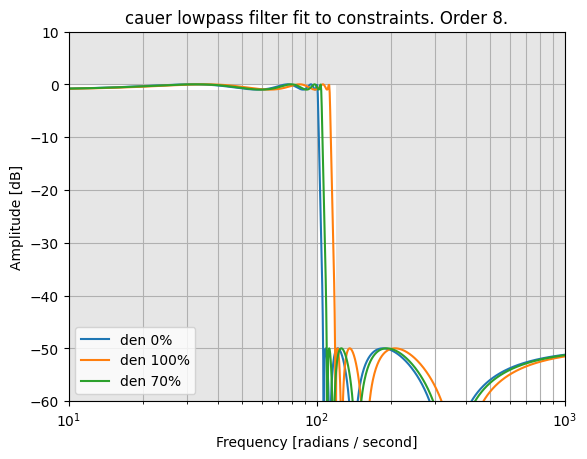

TransferFunctionContinuous(
array([3.16227766e-03, 0.00000000e+00, 5.37505205e+02, 0.00000000e+00,
       2.05188302e+07, 0.00000000e+00, 2.88217362e+11, 0.00000000e+00,
       1.36824993e+15]),
array([1.00000000e+00, 9.52031619e+01, 3.22846369e+04, 2.43732226e+06,
       3.56448637e+08, 1.98610246e+10, 1.48665964e+12, 5.02507437e+13,
       1.53520167e+15]),
dt: None
)


In [15]:
from scipy import signal
import scipy
import numpy as np
import matplotlib.pyplot as plt


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def error_bound(a, b, err):
    n = np.log((b - a) / err) / np.log(2)
    return int(np.ceil(n))
    
def validate_interval(f, x0, x1):
    return f(x0) * f(x1) < 0
# solve for root using bisection method
def bisection(f, interval, tol):
    """
    param f: find root for function
    param interval: within range
    param tol: root accuracy tolerance
    """

    # extract interval start and end points
    x0, x1 = interval[0], interval[1]

    if x0>x1:
        xaux = x0
        x0=x1
        x1=xaux


    # check interval can be used to solve for root
    if not validate_interval(f, x0, x1):
        return

    # iterations required to find the root within a specified error bound
    n = error_bound(x0, x1, tol)

    counter = 1

    # iterate over error bound
    while True:

        # calculate root approximation
        root_approx = x0 + ((x1 - x0) / 2)

        # evaluate y at current estimate
        y = f(root_approx)

        # check tolerance condition
        if -tol < y < tol:
            # check that error bound actually worked
            print(counter, n)

            # return root approximation
            return root_approx

        # check if next segment is left of bisection
        if validate_interval(f, x0, root_approx):
            x1 = root_approx
        else:
            x0 = root_approx

        # increment counter
        counter += 1

def get_min_order(filter_name, Wpass, Watt, Gp, Ga):
    if filter_name == 'butter':
        ordfunc = signal.buttord
    elif filter_name == 'cheby':
        ordfunc = signal.cheb1ord
    elif filter_name == 'cheby2':
        ordfunc = signal.cheb2ord
    elif filter_name == 'cauer':
        ordfunc = signal.ellipord
    else:
        return
    return ordfunc(Wpass, Watt, Gp, Ga, True)


def get_filter(filter_name, filter_type, N, Wn,Gp, Ga, denorm):

    

    if filter_name == 'butter':
        filterfunc = signal.butter
    elif filter_name == 'cheby':
        filterfunc = lambda ord, w3db, type_str, analog: signal.cheby1(ord, -Gp, w3db, type_str, analog)
    elif filter_name == 'cheby2':
        filterfunc = lambda ord, w3db, type_str, analog: signal.cheby2(ord, -Ga, w3db, type_str, analog)
    elif filter_name == 'cauer':
        filterfunc = lambda ord, w3db, type_str, analog: signal.ellip(ord, -Gp, -Ga, w3db, type_str, analog)
    else:
        return
    
    def getMagnAtWx (order, W3db, Wx):
        num, den = filterfunc(order, W3db, filter_type, True)
        w, h = signal.freqs(num, den, [Wx, W3db])
        res = 20*np.log10(abs(h[0]))
        return(res)


    
    b1, a1 = filterfunc(N, Wn, filter_type, True)
 
    #Busco dos frecuencias para podes hallar una que clave exacto Gp en Wp
    if filter_type=='lowpass':
        Wp1 = Wn
        while (getMagnAtWx(N,Wp1,Wpass)>Gp):
            Wp1*=0.99    
        Wp2 = Wn*1.02
        Wn0 = 1.01*bisection(lambda x: getMagnAtWx(N, x, Wpass)-(Gp), [Wp1, Wp2], 0.01)
    elif filter_type=='highpass':
        Wp1 = Wn
        while (getMagnAtWx(N,Wp1,Wpass)>Gp):
            Wp*=1.01    
        Wp2 = Wn*0.98
        Wn0 = 0.99*bisection(lambda x: getMagnAtWx(N, x, Wpass)-(Gp), [Wp1, Wp2], 0.01)

    

    if filter_type=='lowpass':
        Wa1 = Wn
        while (getMagnAtWx(N,Wa1,Watt)<Ga):
            gan = getMagnAtWx(N,Wa1,Watt)
            Wa1*=1.01   
        Wa2 = Wn*0.98
        Wn100 = 0.99*bisection(lambda x: getMagnAtWx(N, x, Watt)-(Ga), [Wa1, Wa2], 0.01)
    elif filter_type=='highpass':
        Wa1 = Wn
        while (getMagnAtWx(N,Wa1,Watt)<Ga):
            Wa1*=0.99    
        Wa2 = Wn*1.02
        Wn100 = 1.01*bisection(lambda x: getMagnAtWx(N, x, Watt)-(Ga), [Wa1, Wa2], 0.01)

    



    b2, a2 = filterfunc(N, Wn100, filter_type, True)
    w, h2 = signal.freqs(b2, a2, np.logspace(1, 3, 1000))

    Wden = Wn0**(denorm)*Wn100**(1-denorm)
    b3, a3 = filterfunc(N, Wden, filter_type, True)
    w, h3 = signal.freqs(b3, a3, np.logspace(1, 3, 1000))

    b4, a4 = filterfunc(N, Wn0, filter_type, True)
    w, h4 = signal.freqs(b4, a4, np.logspace(1, 3, 1000))



    plt.semilogx(w, 20 * np.log10(abs(h4)), label='den 0%')
    plt.semilogx(w, 20 * np.log10(abs(h2)), label='den 100%')
    plt.semilogx(w, 20 * np.log10(abs(h3)), label='den 70%')

    plt.title(filter_name + ' ' + filter_type + ' filter fit to constraints. Order '+str(N)+'.')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.grid(which='both', axis='both')
    if filter_type=='lowpass':
        plt.fill([0.01*Wpass,  0.01*Wpass,  100*Watt,   100*Watt],[0, 100*(-Gp), 100*(-Gp), 0], '0.9', lw=0) #zona prohibida: amplificación
        plt.fill([0.01*Wpass,  0.01*Wpass,  Wpass,   Wpass],[100*Gp, Gp, Gp, 100*Gp], '0.9', lw=0) #zona prohibida: bajo Gp
        plt.fill([Watt,  100*Watt, 100*Watt, Watt],[0, 0, Ga, Ga], '0.9', lw=0) #zona prohibida: sobre Ga
        
    if filter_type=='highpass':
        plt.fill([0.01*Wpass,  0.01*Wpass,  100*Watt,   100*Watt],[0, 100*(-Gp), 100*(-Gp), 0], '0.9', lw=0) #zona prohibida: amplificación
        plt.fill([0.01*Watt,  0.01*Watt,  Watt,   Watt],[0, Ga, Ga, 0], '0.9', lw=0) #zona prohibida: bajo Gp
        plt.fill([Wpass,  100*Wpass, 100*Wpass, Wpass],[Gp, Gp, 100*Gp, 100*Gp], '0.9', lw=0) #zona prohibida: sobre Ga
    # stop
    plt.axis([10, 1000, Ga-10, 10])
    plt.legend()
    plt.show()
    return [b3, a3],[b1,a1]

""" 
    'butter'
    'cheby'
    'cheby2'
    'cauer'
"""

filter = 'cauer'
filter_type = 'lowpass'
Wpass = 100
Watt = 120
Gp = -1
Ga = -50
deg = 0.5

order, Wn = get_min_order(filter, Wpass, Watt, -Gp, -Ga)

b, a = get_filter(filter,filter_type, order+2, Wn, Gp,Ga,0.7)[0]
b, a = signal.normalize(b,a)
print(signal.TransferFunction(b,a))


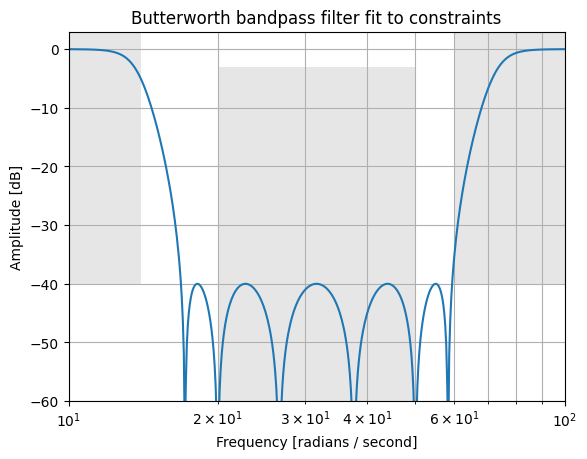

6


In [22]:
from scipy import signal
import scipy
import numpy as np
import matplotlib.pyplot as plt

N, Wn = signal.cheb2ord([20, 50], [14, 60], 3, 40, True)
b, a = signal.cheby2(N, 40, Wn, 'bandstop', True)
w, h = signal.freqs(b, a, np.logspace(1, 2, 500))
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth bandpass filter fit to constraints')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')
plt.fill([1,  14,  14,   1], [-40, -40, 99, 99], '0.9', lw=0) # stop
plt.fill([20, 20,  50,  50], [-99, -3, -3, -99], '0.9', lw=0) # pass
plt.fill([60, 60, 1e9, 1e9], [99, -40, -40, 99], '0.9', lw=0) # stop
plt.axis([10, 100, -60, 3])
plt.show()
print(N)